# Imports, etc.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import datetime 
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_rows',500)

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
from plotnine import *

In [4]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

# Data

### Query

In [5]:
qry = """
    select distinct computed_at_local, 
      code_version, 
      is_backfill, 
      reference_date
    from predict.m_inflight_fulfillment_preds
    where computed_at_local > '2022-04-01'
"""
df = pd.read_sql(qry,conn)

### Date Coverage

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:381: PlotnineWarning: position_stack : Removed 1714 rows containing missing values.


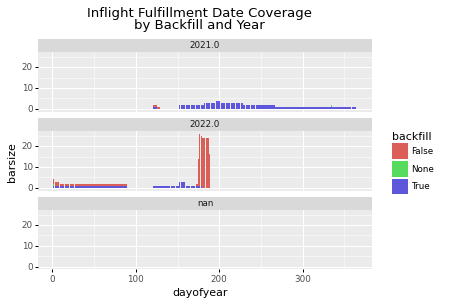

<ggplot: (359264762)>

In [6]:
(
    df.assign(reference_dt = lambda x: pd.to_datetime(x['REFERENCE_DATE']))
    .assign(dom = lambda x: x['reference_dt'])
    .assign(year = lambda x: x['reference_dt'].apply(lambda y: y.year).astype(str))
    .assign(dayofyear = lambda x: x['reference_dt'].apply(lambda y: y.dayofyear))
    .assign(backfill = lambda x: x['IS_BACKFILL'].astype(str))
    .assign(barsize =1)
    
    .pipe(lambda x: ggplot(x, aes(x='dayofyear',y='barsize',fill='backfill'))
         + geom_bar(stat='identity')
         + facet_wrap(['year'],ncol=1)
         + theme(figure_size=(6,6))
         + ggtitle("Inflight Fulfillment Date Coverage\nby Backfill and Year")
         )
)

### Code version coverage

In [7]:
qry = """
    select count(distinct computed_at_local), 
      is_backfill, 
      code_version
    from predict.m_inflight_fulfillment_preds
    where computed_at_local > '2022-05-01'
    group by is_backfill, code_version
"""
pd.read_sql(qry,conn)

,COUNT(DISTINCT COMPUTED_AT_LOCAL),IS_BACKFILL,CODE_VERSION
0,203,True,1.0.4
1,346,True,1.0.3
2,3,None,0.0.1
3,406,False,1.0.3
4,22,False,1.0.4
5,1190,None,None


# Analysis

## Compare Backfill to First Run

In [8]:
qry = """
    with first_run as (
        select *
        from predict.m_inflight_fulfillment_preds
        where reference_date > '2022-05-30'
        and is_backfill = False
        qualify rank() over (
          partition by farm_id, 
            component_id, 
            reference_date, 
            delivery_scheduled_on, 
            prediction_days_ahead 
          order by computed_at) = 1
        
    ),
    backfill as (
        select *
        from predict.m_inflight_fulfillment_preds
        where reference_date > '2022-05-30'
        and is_backfill = True
        qualify rank() over (
          partition by farm_id, 
            component_id, 
            reference_date, 
            delivery_scheduled_on, 
            prediction_days_ahead 
          order by computed_at desc) = 1
    )
    select * from first_run
    union 
    select * from backfill
"""
df = pd.read_sql(qry,conn)

In [9]:
compare_df = (
    df.filter(items=['FARM_ID','COMPONENT_ID','DELIVERY_SCHEDULED_ON','REFERENCE_DATE','PREDICTED_SHORTFALL_LBS_Q50','PREDICTION_DAYS_AHEAD','IS_BACKFILL'])

    .pivot(index=['FARM_ID','COMPONENT_ID','DELIVERY_SCHEDULED_ON','REFERENCE_DATE','PREDICTION_DAYS_AHEAD'],columns='IS_BACKFILL',values='PREDICTED_SHORTFALL_LBS_Q50')
    .reset_index()
    .rename(columns={True:'Backfill',False:'Predicted'})
    .dropna(subset=['Predicted','Backfill'])
    .assign(diff = lambda x: x['Predicted'] - x['Backfill'])
    .query("DELIVERY_SCHEDULED_ON < datetime.date(2022,6,30)")
    
    # Farm 3 may not have good crop mass estimates
    .query('FARM_ID != 3')
)

In [10]:
df.head()

,FARM_ID,COMPONENT_ID,COMPONENT_NAME,DELIVERY_SCHEDULED_ON,HARVEST_SCHEDULED_ON,FACT_DATE,REFERENCE_DATE,SHORTFALL_PROBABILITY,PREDICTED_SHORTFALL_LBS_Q10,PREDICTED_SHORTFALL_LBS_Q50,...,HARVEST_MEAN,DEMAND_MEAN,DEMAND_MINUS_SUPPLY_SKETCH,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,IS_BACKFILL,MESSAGE_ID
0,2,6,Arugula,2022-06-27,2022-06-26,2022-06-26,2022-06-23,1.00,0.00,0.00,...,0.00,0.00,"N(-0.0,0.0)",2022-06-28 22:12:57,2022-06-28 18:12:57,3,1.0.3,2ca9710,False,559a8f99-f181-5409-9340-d4ac8efca267
1,2,48,Chrysanthemum Greens,2022-07-17,2022-07-16,2022-07-16,2022-07-07,1.00,0.00,0.00,...,0.00,0.00,float,2022-07-07 00:16:10,2022-07-06 20:16:10,9,1.0.4,3f2413e,False,d726cef8-ffdb-594c-947a-95b8d78c9cb1
2,2,50,Strawberries,2022-07-17,2022-07-16,2022-07-16,2022-06-26,1.00,0.00,0.00,...,0.00,0.00,float,2022-06-26 00:16:03,2022-06-25 20:16:03,20,1.0.3,2ca9710,False,dfb87f1d-87e6-5f1f-8577-242c2025f590
3,2,10,Green Romaine,2022-07-01,2022-06-30,2022-06-30,2022-06-27,0.00,-2171.41,-1939.42,...,318.91,300.49,"N(-1939.42,181.02)",2022-06-27 00:16:19,2022-06-26 20:16:19,3,1.0.3,2ca9710,False,8715a6d6-4220-5efd-861a-fde4bb707020
4,1,40,Red Mizuna,2022-06-30,2022-06-29,2022-06-29,2022-06-21,0.18,-69.62,-29.03,...,0.00,0.00,"N(-29.03,31.67)",2022-06-28 22:06:55,2022-06-28 18:06:55,8,1.0.3,2ca9710,False,a7a86b9e-8fbb-5435-99f6-30abf1b82b7d


In [11]:
def rename_columns(x):
    
    x.columns = ['FARM_ID','COMPONENT_ID','DELIVERY_SCHEDULED_ON','REFERENCE_DATE',
                 'PREDICTION_DAYS_AHEAD','Predicted','Backfill','PredictedComputedAt','BackfillComputedAt']
    return x

In [12]:
compare_df = (
    df.filter(items=['FARM_ID','COMPONENT_ID','DELIVERY_SCHEDULED_ON','REFERENCE_DATE','PREDICTED_SHORTFALL_LBS_Q50','PREDICTION_DAYS_AHEAD','IS_BACKFILL','COMPUTED_AT'])

    .pivot(index=['FARM_ID','COMPONENT_ID','DELIVERY_SCHEDULED_ON','REFERENCE_DATE','PREDICTION_DAYS_AHEAD'],columns='IS_BACKFILL',values=['PREDICTED_SHORTFALL_LBS_Q50','COMPUTED_AT'])
    .droplevel(level='IS_BACKFILL',axis=1)
        .reset_index()

    .pipe(rename_columns) 
#     .rename(columns={True:'Backfill',False:'Predicted'})
    .dropna(subset=['Predicted','Backfill'])
    .assign(diff = lambda x: x['Predicted'] - x['Backfill'])
    .query("DELIVERY_SCHEDULED_ON < datetime.date(2022,6,30)")
    
    # Farm 3 may not have good crop mass estimates
    .query('FARM_ID != 3')
    
        .assign(diff = lambda x: x['diff'].astype(float),
           Backfill = lambda x: x['Backfill'].astype(float),
           Predicted = lambda x: x['Predicted'].astype(float))
)
compare_df

,FARM_ID,COMPONENT_ID,DELIVERY_SCHEDULED_ON,REFERENCE_DATE,PREDICTION_DAYS_AHEAD,Predicted,Backfill,PredictedComputedAt,BackfillComputedAt,diff
35,1,3,2022-06-21,2022-06-20,0,0.0,0.0,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0
43,1,3,2022-06-22,2022-06-20,1,0.0,0.0,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0
44,1,3,2022-06-22,2022-06-21,0,0.0,0.0,2022-06-28 22:06:55,2022-06-30 16:01:16,0.0
52,1,3,2022-06-23,2022-06-20,2,0.0,0.0,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0
53,1,3,2022-06-23,2022-06-21,1,0.0,0.0,2022-06-28 22:06:55,2022-06-30 16:01:16,0.0
...,...,...,...,...,...,...,...,...,...,...
32013,2,50,2022-06-29,2022-06-24,4,0.0,0.0,2022-06-24 13:57:53,2022-06-30 16:10:41,0.0
32014,2,50,2022-06-29,2022-06-25,3,0.0,0.0,2022-06-25 00:15:37,2022-06-30 16:13:54,0.0
32015,2,50,2022-06-29,2022-06-26,2,0.0,0.0,2022-06-26 00:16:03,2022-06-30 16:17:01,0.0
32016,2,50,2022-06-29,2022-06-27,1,0.0,0.0,2022-06-27 00:16:19,2022-06-30 16:19:49,0.0


### First Run vs Backfill by Prediction Days Ahead

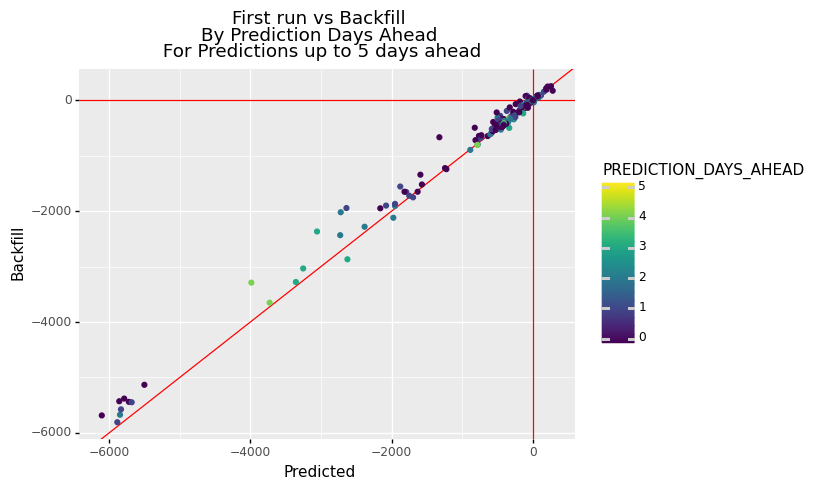

<ggplot: (359563060)>

In [13]:
(
    compare_df

    .query('PREDICTION_DAYS_AHEAD < 6')
#     .query('Predicted > -2500')
    .query('abs(diff/Backfill) > 0.01')

    
    .pipe(lambda x: ggplot(x, aes(x='Predicted',y='Backfill',color='PREDICTION_DAYS_AHEAD')) 
    
    + geom_vline(xintercept=0,color='red')
    + geom_hline(yintercept=0,color='red')
    + geom_abline(intercept=0,slope=1,color='red')
    + geom_point()
    + ggtitle("First run vs Backfill\nBy Prediction Days Ahead\n For Predictions up to 5 days ahead")
))

### First Run vs Backfill by Component

In [14]:
compare_df

,FARM_ID,COMPONENT_ID,DELIVERY_SCHEDULED_ON,REFERENCE_DATE,PREDICTION_DAYS_AHEAD,Predicted,Backfill,PredictedComputedAt,BackfillComputedAt,diff
35,1,3,2022-06-21,2022-06-20,0,0.0,0.0,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0
43,1,3,2022-06-22,2022-06-20,1,0.0,0.0,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0
44,1,3,2022-06-22,2022-06-21,0,0.0,0.0,2022-06-28 22:06:55,2022-06-30 16:01:16,0.0
52,1,3,2022-06-23,2022-06-20,2,0.0,0.0,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0
53,1,3,2022-06-23,2022-06-21,1,0.0,0.0,2022-06-28 22:06:55,2022-06-30 16:01:16,0.0
...,...,...,...,...,...,...,...,...,...,...
32013,2,50,2022-06-29,2022-06-24,4,0.0,0.0,2022-06-24 13:57:53,2022-06-30 16:10:41,0.0
32014,2,50,2022-06-29,2022-06-25,3,0.0,0.0,2022-06-25 00:15:37,2022-06-30 16:13:54,0.0
32015,2,50,2022-06-29,2022-06-26,2,0.0,0.0,2022-06-26 00:16:03,2022-06-30 16:17:01,0.0
32016,2,50,2022-06-29,2022-06-27,1,0.0,0.0,2022-06-27 00:16:19,2022-06-30 16:19:49,0.0


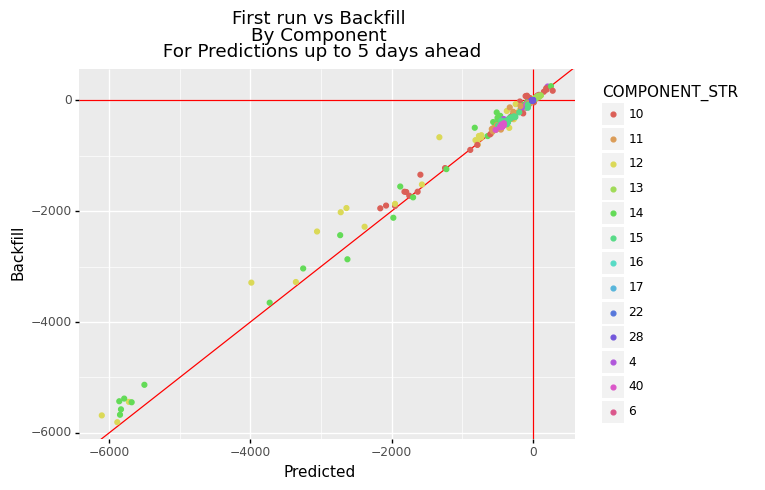

<ggplot: (356707572)>

In [15]:
(
    compare_df
    .query('PREDICTION_DAYS_AHEAD < 6')
#     .query('Predicted > -2500')
    .query('abs(diff/Backfill) > 0.01')
    .assign(COMPONENT_STR = lambda x: x['COMPONENT_ID'].astype(str))
    .pipe(lambda x: ggplot(x, aes(x='Predicted',y='Backfill',color='COMPONENT_STR')) 
    
    + geom_vline(xintercept=0,color='red')
    + geom_hline(yintercept=0,color='red')
    + geom_abline(intercept=0,slope=1,color='red')
    + geom_point()
    + ggtitle("First run vs Backfill\nBy Component\n For Predictions up to 5 days ahead")
))

### Backfill vs Predicted Ratio by Predicted Days Ahead

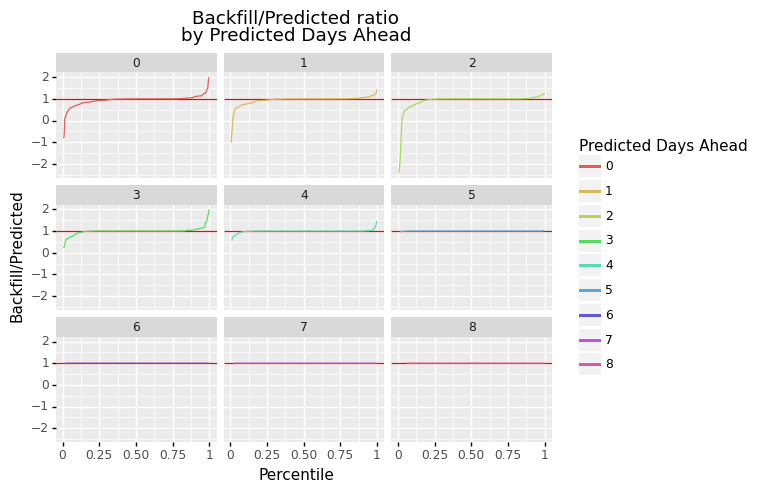

<ggplot: (362915485)>

In [16]:
cutoff_df = (
    compare_df
    .query('Predicted != 0')
    .query('Backfill != 0')

    .assign(pred_ratio = lambda x: ((x['Backfill'])/x['Predicted']))

    .assign(n_pred_day = lambda x: x.groupby('PREDICTION_DAYS_AHEAD')['Backfill'].transform('size'))
    .assign(ones = lambda x: 1/x['n_pred_day'])

    .sort_values('pred_ratio', ascending=True)
    .assign(cum_pct = lambda x: x.groupby(['PREDICTION_DAYS_AHEAD'])['ones'].cumsum())
    .assign(prediction_days_ahead_str = lambda x: x['PREDICTION_DAYS_AHEAD'].astype(str))
)
(
    cutoff_df
    .query("PREDICTION_DAYS_AHEAD<10")

    .pipe(lambda df: ggplot(df, aes(x='cum_pct',y='pred_ratio',color='prediction_days_ahead_str'))
         + geom_hline(yintercept=1,color='red')
         + geom_line()
         + facet_wrap('prediction_days_ahead_str')
         + labs(y="Backfill/Predicted",x='Percentile',color="Predicted Days Ahead")
         + ggtitle("Backfill/Predicted ratio\nby Predicted Days Ahead")
         )
)

In [17]:
(
    cutoff_df
    .assign(rnk = lambda x: x.groupby('PREDICTION_DAYS_AHEAD')['cum_pct'].transform(max))
    .query('cum_pct == rnk')
    .sort_values("PREDICTION_DAYS_AHEAD")
)

,FARM_ID,COMPONENT_ID,DELIVERY_SCHEDULED_ON,REFERENCE_DATE,PREDICTION_DAYS_AHEAD,Predicted,Backfill,PredictedComputedAt,BackfillComputedAt,diff,pred_ratio,n_pred_day,ones,cum_pct,prediction_days_ahead_str,rnk
28853,2,28,2022-06-28,2022-06-27,0,0.5625,1.125,2022-06-27 00:16:19,2022-06-30 16:19:49,-0.5625,2.000000,189,0.005291,1.0,0,1.0
6014,1,13,2022-06-23,2022-06-21,1,1.3500,1.950,2022-06-28 22:06:55,2022-06-30 16:01:16,-0.6000,1.444444,159,0.006289,1.0,1,1.0
5079,1,12,2022-06-28,2022-06-25,2,-268.7100,-342.790,2022-06-25 00:15:37,2022-06-30 16:13:54,74.0800,1.275688,142,0.007042,1.0,2,1.0
28878,2,28,2022-06-29,2022-06-25,3,0.5625,1.125,2022-06-25 00:15:37,2022-06-30 16:13:54,-0.5625,2.000000,121,0.008264,1.0,3,1.0
28821,2,28,2022-06-27,2022-06-22,4,1.2300,1.800,2022-06-28 22:09:31,2022-06-30 16:03:34,-0.5700,1.463415,98,0.010204,1.0,4,1.0
7232,1,14,2022-06-29,2022-06-23,5,-110.4800,-111.700,2022-06-28 22:12:57,2022-06-30 16:06:17,1.2200,1.011043,74,0.013514,1.0,5,1.0
19243,2,10,2022-06-27,2022-06-20,6,-2068.0400,-2070.140,2022-06-28 22:04:24,2022-06-30 15:58:22,2.1000,1.001015,57,0.017544,1.0,6,1.0
19270,2,10,2022-06-28,2022-06-20,7,-2021.7100,-2023.810,2022-06-28 22:04:24,2022-06-30 15:58:22,2.1000,1.001039,38,0.026316,1.0,7,1.0
12549,1,28,2022-06-29,2022-06-20,8,-31.0800,-31.080,2022-06-28 22:04:24,2022-06-30 15:58:22,0.0000,1.000000,18,0.055556,1.0,8,1.0


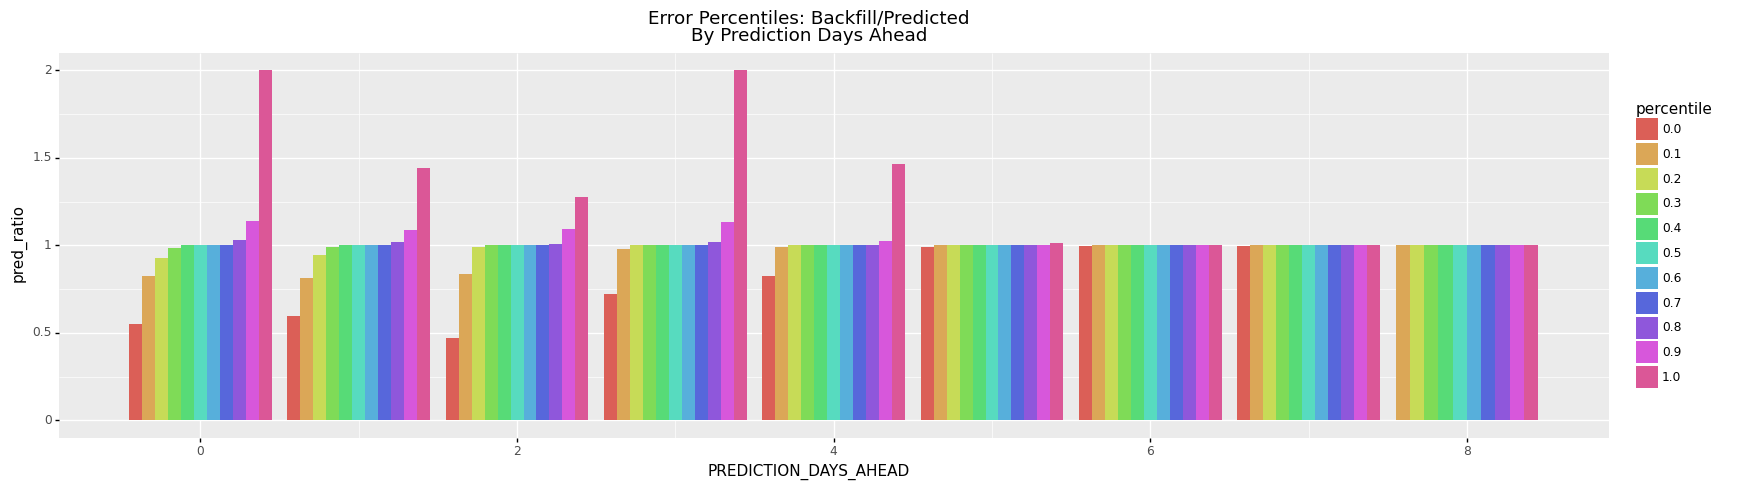

<ggplot: (359338686)>

In [18]:
(
    cutoff_df
    .assign(cum_pct_rnd = lambda x: np.around(x['cum_pct'],1))
    .assign(rnk = lambda x: x.groupby(['PREDICTION_DAYS_AHEAD','cum_pct_rnd'])['cum_pct'].transform(max))
    .query('rnk == cum_pct')
    .assign(percentile = lambda x: x['cum_pct_rnd'].astype(str))
#     .query('cum_pct_rnd >= .7')
    
    .pipe(lambda df: ggplot(df, aes(x='PREDICTION_DAYS_AHEAD',y='pred_ratio',fill='percentile'))
         + geom_bar(stat='identity',position='dodge')
#          + scale_y_log10()
         + ggtitle("Error Percentiles: Backfill/Predicted\nBy Prediction Days Ahead")
         + theme(figure_size=(20,5)))
)

In [19]:
# Interpretation: in 90% of cases, prediction - backfill relative to magnitude is a small difference. In the 10% most egregious cases it can be significant.

## Egregious Cases

In [20]:
(
    compare_df
    .query('Predicted != 0')
    .query('Backfill != 0')
#     .assign(pred_ratio = lambda x: abs(1 - (x['Backfill']/x['Predicted'])))    
    .assign(pred_ratio = lambda x: abs((x['Predicted']-x['Backfill'])/x['Predicted']))
    .sort_values('pred_ratio',ascending=False)
).head(n=20)

,FARM_ID,COMPONENT_ID,DELIVERY_SCHEDULED_ON,REFERENCE_DATE,PREDICTION_DAYS_AHEAD,Predicted,Backfill,PredictedComputedAt,BackfillComputedAt,diff,pred_ratio
19275,2,10,2022-06-28,2022-06-25,2,15.6600,-37.7900,2022-06-25 00:15:37,2022-06-30 16:13:54,53.4500,3.413155
2845,1,10,2022-06-24,2022-06-21,2,-2.7700,5.5300,2022-06-28 22:06:55,2022-06-30 16:01:16,-8.3000,2.996390
2979,1,10,2022-06-29,2022-06-26,2,-41.1800,42.1200,2022-06-26 00:16:03,2022-06-30 16:17:01,-83.3000,2.022827
2952,1,10,2022-06-28,2022-06-26,1,-81.7800,82.6500,2022-06-26 00:16:03,2022-06-30 16:17:01,-164.4300,2.010638
2981,1,10,2022-06-29,2022-06-28,0,-51.7400,41.4000,2022-06-28 00:16:12,2022-06-30 16:22:38,-93.1400,1.800155
2953,1,10,2022-06-28,2022-06-27,0,-101.4400,75.6100,2022-06-27 00:16:19,2022-06-30 16:19:49,-177.0500,1.745367
2980,1,10,2022-06-29,2022-06-27,1,-68.9300,35.0100,2022-06-27 00:16:19,2022-06-30 16:19:49,-103.9400,1.507907
28878,2,28,2022-06-29,2022-06-25,3,0.5625,1.1250,2022-06-25 00:15:37,2022-06-30 16:13:54,-0.5625,1.000000
28853,2,28,2022-06-28,2022-06-27,0,0.5625,1.1250,2022-06-27 00:16:19,2022-06-30 16:19:49,-0.5625,1.000000
24516,2,15,2022-06-25,2022-06-24,0,-69.2400,-135.0700,2022-06-24 13:57:53,2022-06-30 16:10:41,65.8300,0.950751


In [21]:
qry = """
    select *,
    case when computed_at between '2022-06-30 16:01' and '2022-06-30 16:02' then 1 else 0 end as is_backfill
    from warehouse.v_inflight_fulfillment_states
    where delivery_scheduled_on  = '2022-06-24'
      and component_id = 10
      and farm_id = 1
      and (
        (computed_at between '2022-06-30 16:01' and '2022-06-30 16:02')
        or 
        (computed_at between '2022-06-28 22:06' and '2022-06-28 22:07')
      )
"""

pd.read_sql(qry,conn).T

,0,1
DELIVERY_SCHEDULED_ON,2022-06-24,2022-06-24
HARVEST_SCHEDULED_ON,2022-06-23,2022-06-23
FARM_ID,1,1
COMPONENT_ID,10,10
HARVEST_PDF_LESS_THAN_ZERO,0,0
HARVEST_Q10,9,9
HARVEST_Q50,14.01,14.01
HARVEST_Q90,19.01,19.01
HARVEST_MEAN,14.01,14.01
HARVEST_SKETCH,"N(14.01,3.91)","N(14.01,3.91)"


In [22]:
qry = """
select *,
case when computed_at between '2022-06-30 16:13' and '2022-06-30 16:14' then 1 else 0 end as is_backfill
from warehouse.v_inflight_fulfillment_states
where delivery_scheduled_on  = '2022-06-28'
and component_id = 10
and farm_id = 2
and ((computed_at between '2022-06-30 16:13' and '2022-06-30 16:14') or
     (computed_at between '2022-06-25 00:15' and '2022-06-25 00:16')
    )
"""

pd.read_sql(qry,conn).T

,0,1
DELIVERY_SCHEDULED_ON,2022-06-28,2022-06-28
HARVEST_SCHEDULED_ON,2022-06-27,2022-06-27
FARM_ID,2,2
COMPONENT_ID,10,10
HARVEST_PDF_LESS_THAN_ZERO,0,0
HARVEST_Q10,430.2,422.01
HARVEST_Q50,453.62,449.43
HARVEST_Q90,477.05,476.85
HARVEST_MEAN,453.62,449.43
HARVEST_SKETCH,"N(453.62,18.28)","N(449.43,21.4)"


In [23]:
qry = """
select *,
case when computed_at between '2022-06-30 16:13' and '2022-06-30 16:14' then 1 else 0 end as is_backfill
from warehouse.v_inflight_fulfillment_states
where delivery_scheduled_on  = '2022-06-29'
and component_id = 6
and farm_id = 3
and ((computed_at between '2022-06-30 16:13' and '2022-06-30 16:14') or
     (computed_at between '2022-06-25 00:15' and '2022-06-25 00:16')
    )
"""

pd.read_sql(qry,conn).T

,0,1
DELIVERY_SCHEDULED_ON,2022-06-29,2022-06-29
HARVEST_SCHEDULED_ON,2022-06-28,2022-06-28
FARM_ID,3,3
COMPONENT_ID,6,6
HARVEST_PDF_LESS_THAN_ZERO,NaN,0
HARVEST_Q10,33.58,0
HARVEST_Q50,33.58,0
HARVEST_Q90,33.58,0
HARVEST_MEAN,33.58,0
HARVEST_SKETCH,"N(33.58,0.0)","N(0.0,0.0)"
